In [15]:
import cv2
import numpy as np
from skimage import measure
from matplotlib import pyplot as plt
import codecs
import itertools
import sys
import os

plt.rcParams["figure.figsize"] = (20,10)

sys.path.insert(0, './models')
import model_2lstm, model_3gru, model_lstm_gru, model_attention, model_2lstm_new, model_attention_new


def load_image(path):
    return cv2.imread(path, cv2.IMREAD_GRAYSCALE)


def inverse(image):
    return cv2.bitwise_not(image)


def otsu_threshold(image):
    norm_img = np.zeros(image.shape)
    img = cv2.normalize(image, norm_img, 0, 255, cv2.NORM_MINMAX)
    blur = cv2.GaussianBlur(img, (3, 3), 0)
    _, img = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    return img


def draw_image(img):
    plt.imshow(img, cmap='gray', vmin=0, vmax=255)
    plt.show()
    

def skew_angle(image):
    coords = np.column_stack(np.where(image > 0))
    angle = cv2.minAreaRect(coords)[-1]
    if angle < -45 or angle > 45:
        return 0
    else:
        angle = -angle
    return angle


def deskew_image(image, angle):
    h, w = image.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    image_rotated = cv2.warpAffine(image, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
    return image_rotated


def connected_components(image):
    mask = image > 0.
    labeled_image, num = measure.label(mask, connectivity=2, return_num=True)
    labeled_image = (labeled_image > 0) * 255.
    return np.array(labeled_image).astype(np.uint8)


def find_text_area(image):
    image = inverse(image)
    contours, hierarchy = cv2.findContours(image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    mask = np.zeros(image.shape, dtype=np.uint8)
    cv2.fillPoly(mask, contours, [255,255,255])
    mask = 255 - mask
    result = inverse(cv2.bitwise_or(image, mask))
    
    result = connected_components(result)
    contours, hierarchy = cv2.findContours(result, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    min_x = 999999
    max_x = 0
    min_y = 999999
    max_y = 0
    for contour in reversed(contours):
        [x, y, w, h] = cv2.boundingRect(contour)
        if x < min_x:
            min_x = x - 2
        if x+w > max_x:
            max_x = x + w + 2
        if y < min_y:
            min_y = y - 2
        if y+h > max_y:
            max_y = y + h + 2
            
        min_x = max(min_x, 0)
        min_y = max(min_y, 0)
        max_x = min(max_x, image.shape[1])
        max_y = min(max_y, image.shape[0])
    return result[min_y:max_y, min_x:max_x]


def find_line_text_area(image):
    contours, hierarchy = cv2.findContours(image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    min_x = 999999
    max_x = 0
    min_y = 999999
    max_y = 0
    for contour in reversed(contours):
        [x, y, w, h] = cv2.boundingRect(contour)
        if x < min_x:
            min_x = x - 2
        if x+w > max_x:
            max_x = x + w + 2
        if y < min_y:
            min_y = y - 2
        if y+h > max_y:
            max_y = y + h + 2
            
        min_x = max(min_x, 0)
        min_y = max(min_y, 0)
        max_x = min(max_x, image.shape[1])
        max_y = min(max_y, image.shape[0])
    return image[min_y:max_y, min_x:max_x]


def get_lines_of_text(image):
    hist = cv2.reduce(image, 1, cv2.REDUCE_AVG).reshape(-1)
    th = 1
    h = image.shape[0]
    uppers = [y-2 for y in range(h - 2) if hist[y] <= th < hist[y + 2]]
    lowers = [y+2 for y in range(h - 2) if hist[y] > th >= hist[y + 2]]

    lines_of_text = []
    for line in zip(uppers, lowers):
        line_checked = [line[0], line[1]]
        if line[0] < 0:
            line_checked[0] = 0
        if line[1] >= image.shape[0]:
            line_checked[1] = image.shape[0] - 1
        lines_of_text.append(line_checked)

    for idx, line in enumerate(lines_of_text):
        if idx > 0 and line[0] <= lines_of_text[idx-1][1]:
            lines_of_text[idx-1] = (lines_of_text[idx-1][0], line[1])
            del lines_of_text[idx]
        elif line[1] - line[0] < 3:
            del lines_of_text[idx]

    text_lines = []
    for line in lines_of_text:
        text_lines.append(image[line[0]:line[1], :])
    return text_lines


def split_line_of_text(image):
    hist = cv2.reduce(image, 0, cv2.REDUCE_AVG).reshape(-1)
    th = 1
    w = image.shape[1]
    uppers = [x-2 for x in range(w - 2) if hist[x] <= th < hist[x + 2]]
    lowers = [x+2 for x in range(w - 2) if hist[x] > th >= hist[x + 2]]

    lines_of_text = []
    for line in zip(uppers, lowers):
        line_checked = [line[0], line[1]]
        if line[0] < 0:
            line_checked[0] = 0
        if line[1] >= image.shape[0]:
            line_checked[1] = image.shape[0] - 1
        lines_of_text.append(line_checked)

    for idx, line in enumerate(lines_of_text):
        if idx > 0 and line[0] <= lines_of_text[idx-1][1]:
            lines_of_text[idx-1] = (lines_of_text[idx-1][0], line[1])
            del lines_of_text[idx]
        elif line[1] - line[0] < 3:
            del lines_of_text[idx]

#     print(lines_of_text)
    text_lines = []
    for line in lines_of_text:
        text_lines.append(image[line[0]:line[1], :])
    return text_lines

    
def resize_image(image, new_size_min=32, new_size_max=64):
    img_h, img_w = image.shape[:2]
    if img_h < new_size_min:
        scale_factor = new_size_min // img_h + 1
    elif img_h > new_size_max:
        scale_factor = 1. / (float)(img_h // new_size_max + 1)
    else:
        scale_factor = 1
    resized = cv2.resize(image, None, fx=scale_factor, fy=scale_factor, interpolation=cv2.INTER_CUBIC)
    return resized


def pad_image(image, height=64, width=4096, padding=16):
    image = resize_image(image)
    new_image = np.zeros((height, width))
    new_image[:image.shape[0], padding:padding+image.shape[1]] = image
    return new_image.astype(np.uint8)


def normalize_image(image):
    image = np.swapaxes(image, 0, 1)
    image = np.expand_dims(image, -1)
    image = np.expand_dims(image, 0)
    image = (image / 255.) * 2. - 1.
    return image


def get_classes(classes_file='./classes.txt'):
    with codecs.open(classes_file, 'r', encoding='utf-8') as cF:
        data = cF.read().split('\r\n')
    return data


def classes_to_text(classes, data):
    output = ''
    for i in range(classes.shape[0]):
        out_best = list(np.argmax(classes[i, 2:], axis=1))
        out_best = [k for k, g in itertools.groupby(out_best)]  # remove overlap value
        text = ''
        for c in out_best:
            if 0 < c < len(data):
                text += data[c]
        output = output + text + ' '
    return output

In [16]:
# model_architectures = ['2lstm', '3gru', 'lstm_gru']
model_architectures = ['2lstm_new', '2lstm', '3gru', 'lstm_gru', 'attention_new', 'attention']
# model_architectures = ['2lstm_new']
# model_architectures = ['attention_new']

data = get_classes()

images_dir = './input/'
model_dir = './models/'
weights = [f'{model_dir}weights_{model_architectures[i]}.h5' for i in range(len(model_architectures))]

models = [model_2lstm_new.get_model(weights[0]), model_2lstm.get_model(weights[1]), 
          model_3gru.get_model(weights[2]), model_lstm_gru.get_model(weights[3]), 
          model_attention_new.get_model(weights[4]), model_attention.get_model(weights[5])]

# models = [model_2lstm_new.get_model(weights[0])]
# models = [model_attention_new.get_model(weights[0])]

In [17]:
test_data = [f'{images_dir}{img}' for img in os.listdir(f'{images_dir}')]

image_paths = [x for x in test_data if '.png' in x or '.jpg' in x]
label_paths = [x for x in test_data if '.txt' in x]

In [20]:
# for image_path in image_paths:
def extract_text(image_path):
    image = load_image(image_path)
    draw_image(image)
    
    image = inverse(image)
#     draw_image(image)
    
    image_otsu = otsu_threshold(image)
#     draw_image(image_otsu)
    
    angle = skew_angle(image_otsu)
    image_deskewed = deskew_image(image_otsu, angle)
#     draw_image(image_deskewed)
    
    image_crop = find_text_area(image_deskewed)
#     draw_image(image_crop)
    
    image_lines = get_lines_of_text(image_crop)
    predictions_all = []
    for line in image_lines:
        line_text = find_line_text_area(line)
        draw_image(line_text)
        
#         text_parts = split_line_of_text(line_text)
#         for text_part in text_parts:
        text_part = pad_image(line_text)
        text_part = normalize_image(text_part)
    
        predictions = []
        for model_name, model in zip(model_architectures, models):
            pred = model.predict(text_part)
            predictions.append(pred)
            output_text = classes_to_text(pred, data)
            print(f'Model: {model_name} -> {output_text}')
            
#         predictions = np.array(predictions)
#         predictions_avg = np.average(predictions, axis=0)
#         predictions_all.append(predictions_avg)
        
#     print('-------')
#     for line in predictions_all:
#         output_text = classes_to_text(line, data)
#         print(f'Average: {output_text}')
    

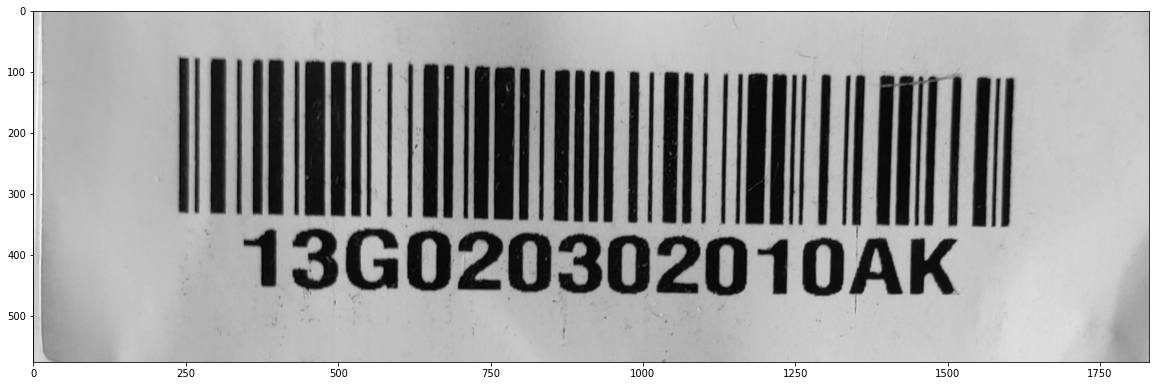

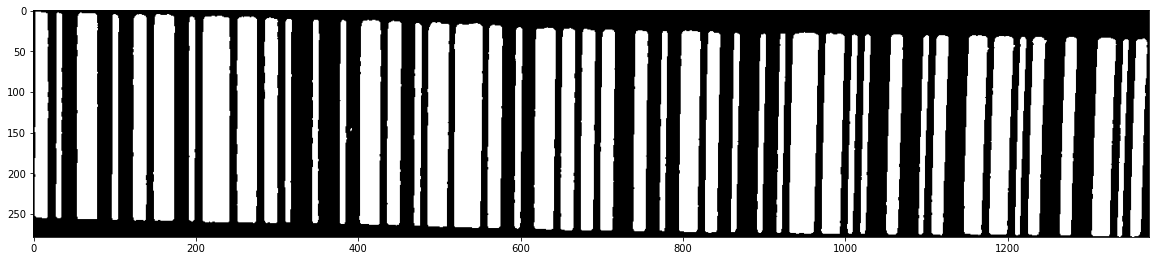

Model: 2lstm_new -> II" 
Model: 2lstm -> MMYYY 
Model: 3gru -> II 
Model: lstm_gru -> IIII/, 
Model: attention_new ->  
Model: attention -> mA.IDmA 


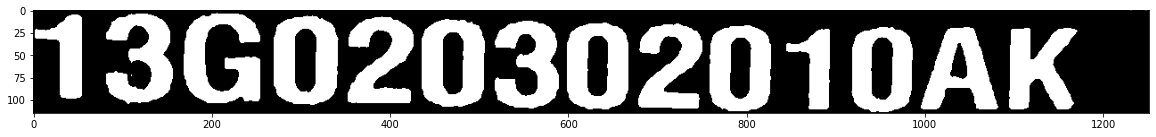

Model: 2lstm_new -> 183012030201DAk 
Model: 2lstm -> 13GiD2030201DAK 
Model: 3gru -> 34020302010AK 
Model: lstm_gru -> 13GD20302010AK 
Model: attention_new -> 18DRD30R0DA 
Model: attention -> m03DGD0D01D3D0JD0J10D0mAmK@Di 


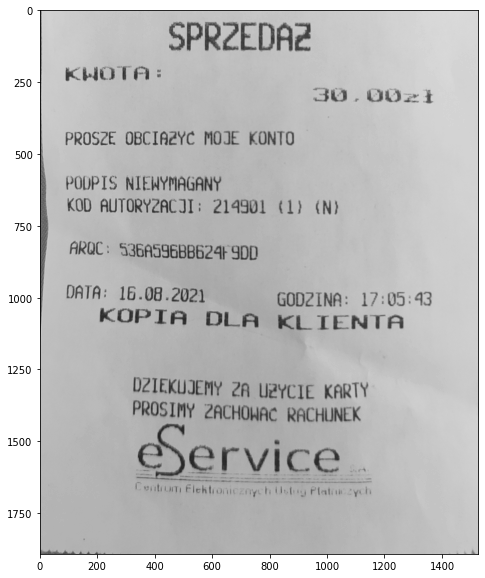

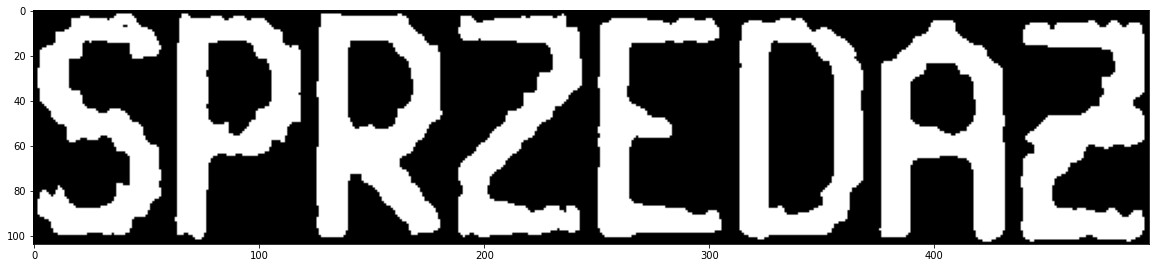

Model: 2lstm_new -> DPRCEDDC 
Model: 2lstm -> PRZEDhd 
Model: 3gru -> PRZEDAZ 
Model: lstm_gru -> PR&EDHd 
Model: attention_new -> SPR2EDRA 
Model: attention -> S0PmRDoS@DmADmA 


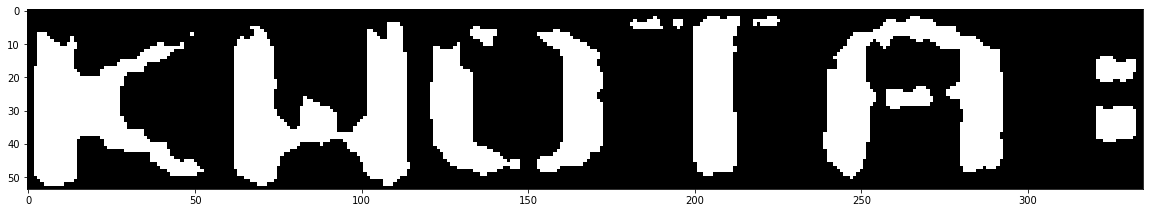

Model: 2lstm_new -> CACSICD: 
Model: 2lstm -> KWNG)IF1i 
Model: 3gru -> WWC)I^1' 
Model: lstm_gru -> KW/L)"IF1i 
Model: attention_new -> KL)"(o 
Model: attention -> KDmA)J-mJ+mD-mJA 


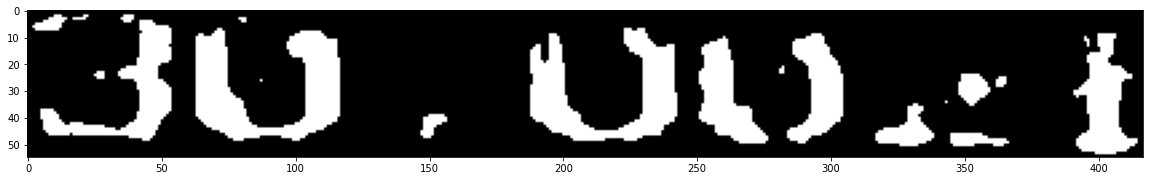

Model: 2lstm_new -> GN0.(U1O.:L 
Model: 2lstm -> 5J.CJl).ct 
Model: 3gru -> C.L1).z1 
Model: lstm_gru -> LD.QDGDLzt 
Model: attention_new -> LO, 
Model: attention -> D)D.DAJDIDADi 


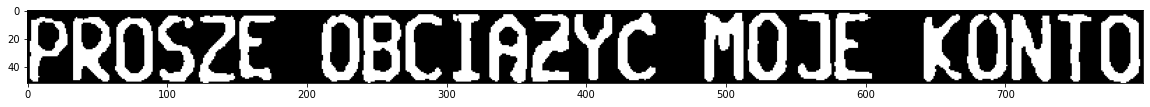

Model: 2lstm_new -> PROSCFDBCIBANCMOCEKOMIO 
Model: 2lstm -> RDSZEUBCIhdYCRDJEKUNTD 
Model: 3gru -> R0SZEOBCINCYCMOLEXONIO 
Model: lstm_gru -> R0S&EBCIRdYCMOIEKDNIO 
Model: attention_new -> RS2ECDBCEAHEDCNTDo 
Model: attention -> P^RDSDED^DBC3DJBRAYC^ADED^K@DAMIDi 


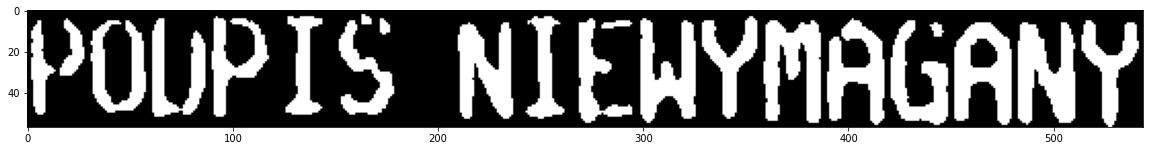

Model: 2lstm_new -> OUPTSWIEWMRBW 
Model: 2lstm -> UUPISNICWYYMGFNY 
Model: 3gru -> OMRISNIEWYMAGWNY 
Model: lstm_gru -> GLPISNIEWMMAGAN* 
Model: attention_new -> MUPISNMHMASRMo 
Model: attention -> PDPIDSDmMImGDy4yYA4Di&DMyY@Di 


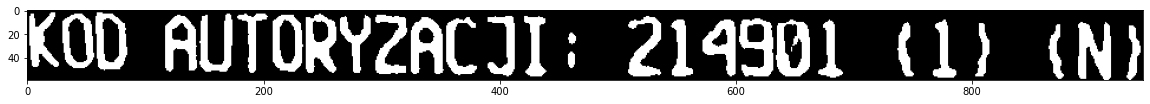

Model: 2lstm_new -> ODRUIDBNZBCJI:214001(1)(MV 
Model: 2lstm -> DDHLTDRRZhCJ:21430](])(N) 
Model: 3gru -> ODMIIMRYZACD[:214901(1)(N] 
Model: lstm_gru -> 0DAUIORY&C.J:214B8](1)(N) 
Model: attention_new -> ODRDHReCD:21800)1)o 
Model: attention -> K0JD]AUD[DBRY]DiACJ[:]=J1~4J9J0][])][AN)]1) 


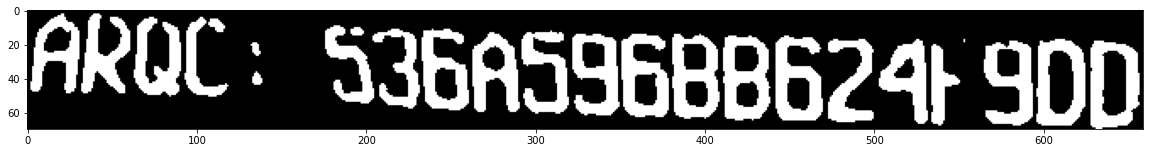

Model: 2lstm_new -> BLSfoBaeap 
Model: 2lstm -> *****^% 
Model: 3gru -> *'WRRR*4 
Model: lstm_gru -> "tP 
Model: attention_new -> Rldedaoa 
Model: attention -> 0m0Dm0m0mOPDmA 


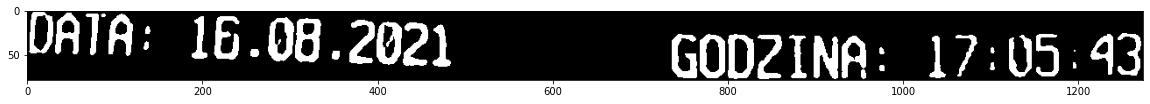

Model: 2lstm_new -> E:EB-B4opaw..62 
Model: 2lstm -> ""*%-W%P6^ 
Model: 3gru -> "P744-^4]m---4-) 
Model: lstm_gru -> """*P-PP*VP* 
Model: attention_new -> O04.oerv.1-s-a 
Model: attention -> -D-D-D-D-D-Do 


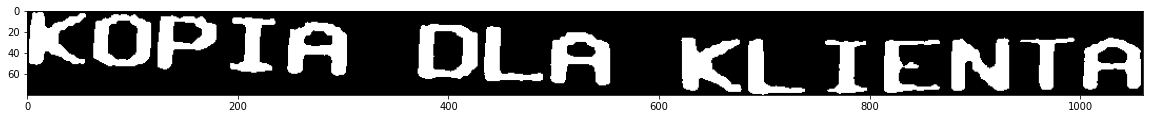

Model: 2lstm_new -> OPIRDLAKLrtwre 
Model: 2lstm -> *"FTP-1W-IFVT^ 
Model: 3gru -> 7"I*P+*K4!F^7+ 
Model: lstm_gru -> *"[*P+**+TF*T 
Model: attention_new -> ODPIRDie-rwre 
Model: attention -> ^v^vDvJ^-D9P+-^-D-4v+DAv4vJ7^-Di 


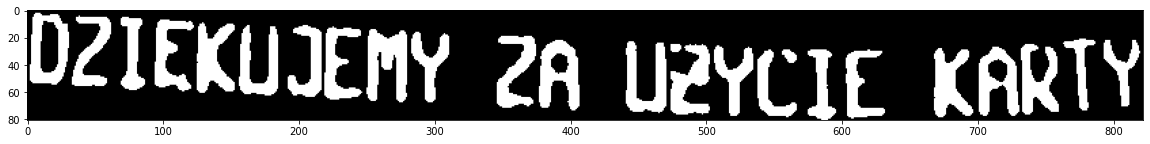

Model: 2lstm_new -> UEUIEMRAuecurkwy 
Model: 2lstm -> FF*4V*FW 
Model: 3gru -> F*PR%4H*-'^] 
Model: lstm_gru -> "**PF*+*#" 
Model: attention_new -> REluecvwery 
Model: attention -> D-^-JD-D9DADJADJD4D^Di 


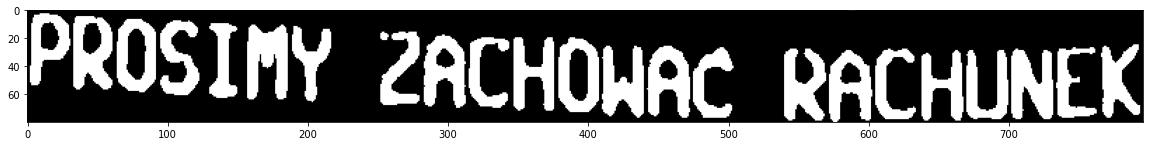

Model: 2lstm_new -> SIMAkwkwcuwk 
Model: 2lstm -> *F*4*%*F 
Model: 3gru -> *M4%#*4 
Model: lstm_gru -> ***##P* 
Model: attention_new -> RRecuvececuve 
Model: attention -> -JD-DJDJ^J5DmMAJD4Do 


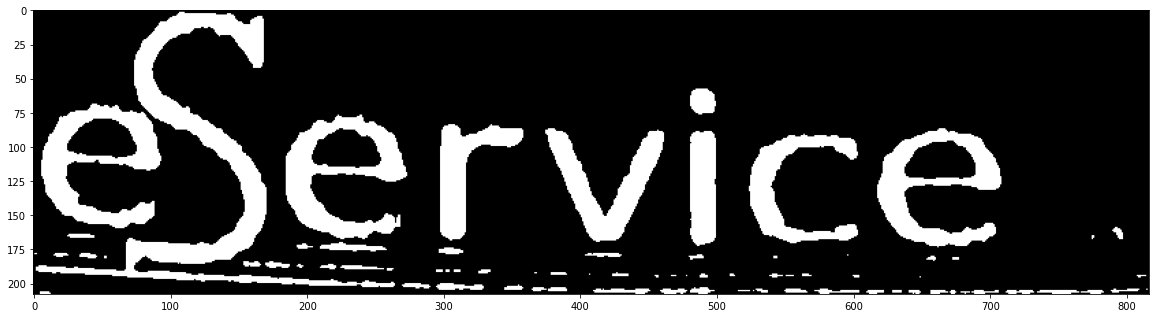

Model: 2lstm_new -> Service 
Model: 2lstm -> ervice 
Model: 3gru -> erxice_ 
Model: lstm_gru -> erv&e_ 
Model: attention_new -> Service 
Model: attention -> DAeomvice.DmDi 


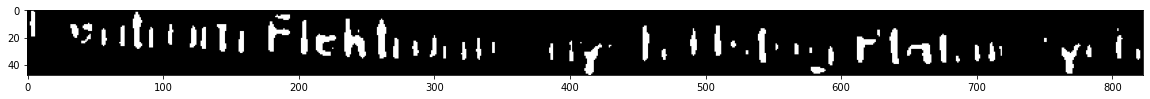

Model: 2lstm_new -> vuthufleHhunn11.1.F1... 
Model: 2lstm -> "F"r---r-FF-r---- 
Model: 3gru -> "I-"I=W--r--rlw-r- 
Model: lstm_gru -> ""--*--"vr---r- 
Model: attention_new -> "w-lek-.-.--.-. 
Model: attention -> -D-Dmo-m-D-D-D-D-D-D-D- 


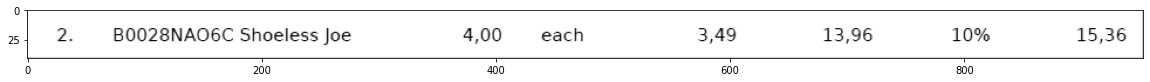

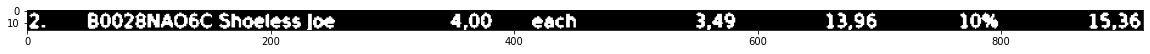

Model: 2lstm_new -> .ANCSCShoelesslbe400ech3131610N15.6 
Model: 2lstm -> -B0R9N-06S1e6l-.D0=AhJ-/1).91%1.6 
Model: 3gru -> .B0929N999B1w=4I4.0Ae4=h0.4%1.9W1%%1N.3 
Model: lstm_gru -> 2.PP24N<0W4$M*Im*4.00<Ah2.4913.9%17%l.% 
Model: attention_new -> 2.AD4A4ShssJbeA,4Ach,45,441DM15,4 
Model: attention -> 3.~J~0~0~38~4~4~0~6~5~5~o~5~J~4.0~0~h~3.49~483.9~6~0~5~1~5.3~6~i 


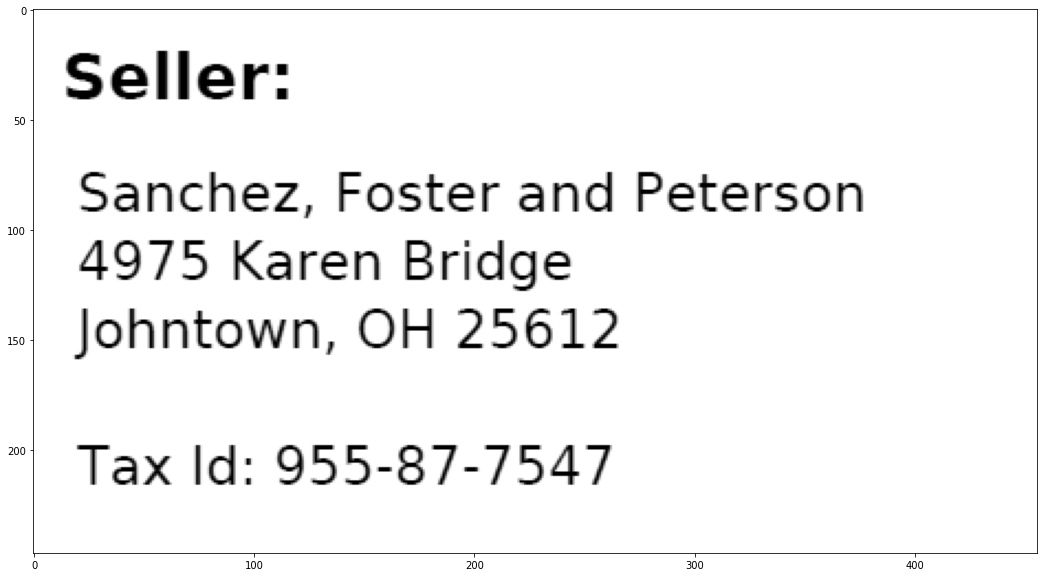

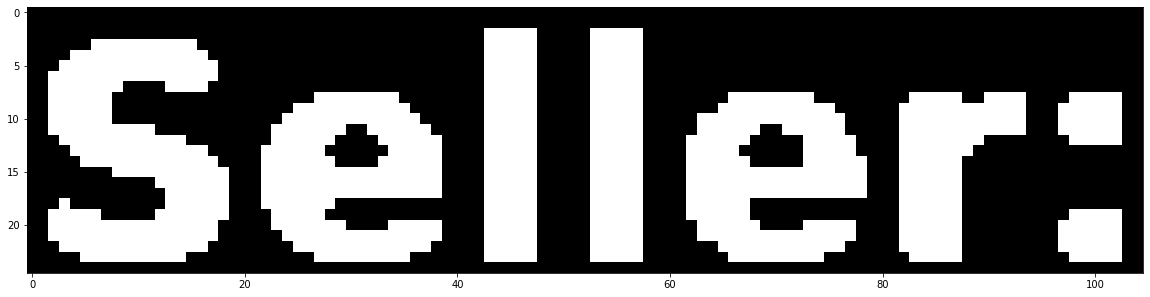

Model: 2lstm_new -> Seller: 
Model: 2lstm -> Sellet: 
Model: 3gru -> eller: 
Model: lstm_gru -> Seller: 
Model: attention_new -> Geler: 
Model: attention -> SoeAdoem:mo 


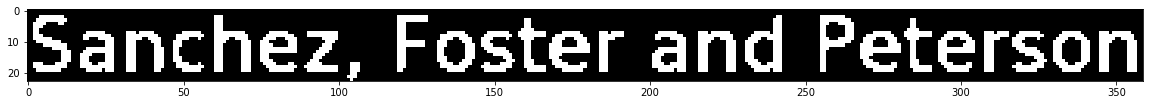

Model: 2lstm_new -> Sanchez,FosterandPeterson 
Model: 2lstm -> -16D4."SV=V-1-"*'*"S 
Model: 3gru -> 4/=I54.F9SI*"4I4"*I=I*9- 
Model: lstm_gru -> 47/744.FPF#]474"#/4/WP7 
Model: attention_new -> Sanche,TosterandPetersono 
Model: attention -> 4D~0~%J~%~-.-4~0~5J~%/-~0~-^-J~J%<0~0-Di 


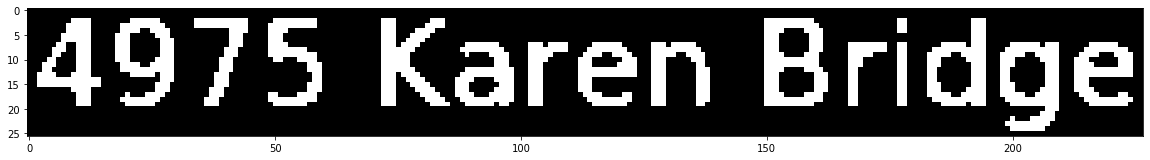

Model: 2lstm_new -> 4915KarenBridge 
Model: 2lstm -> 9/5K-"*DFV63= 
Model: 3gru -> %7P*4"51B"I49* 
Model: lstm_gru -> 4/WKW47P/494 
Model: attention_new -> 175KarenBridgeo 
Model: attention -> 40D/-~D4J~/~JD0~/D~Di 


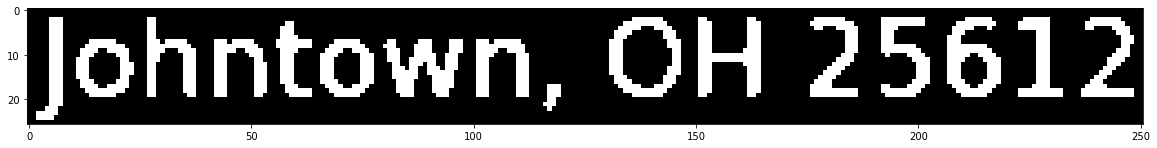

Model: 2lstm_new -> ohntown,OH25612 
Model: 2lstm -> 91DV9V1-Pb4/Pl4 
Model: 3gru -> --9%1.VH4P%44 
Model: lstm_gru -> P779*7.9*4WW]4 
Model: attention_new -> ohohntown,2DH25612 
Model: attention -> JDJ0J~0~4<D.D0~<4D+J3D0+J-Di 


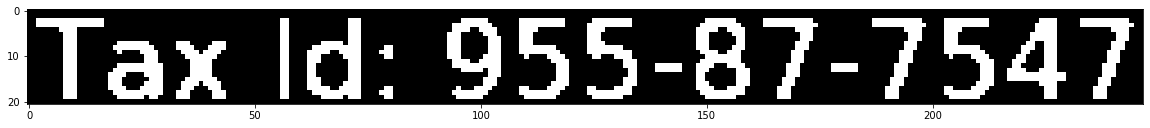

Model: 2lstm_new -> Taxld:O55-871547 
Model: 2lstm -> T-KW/77//--/ 
Model: 3gru -> 4I4-%7P:97:774] 
Model: lstm_gru -> [NPPPPP//+/ 
Model: attention_new -> axl55-877547) 
Model: attention -> J~J4-J~:^0~5J5D^-/D^/+4J4D+Di 


In [24]:
for image_path in image_paths:
    extract_text(image_path)

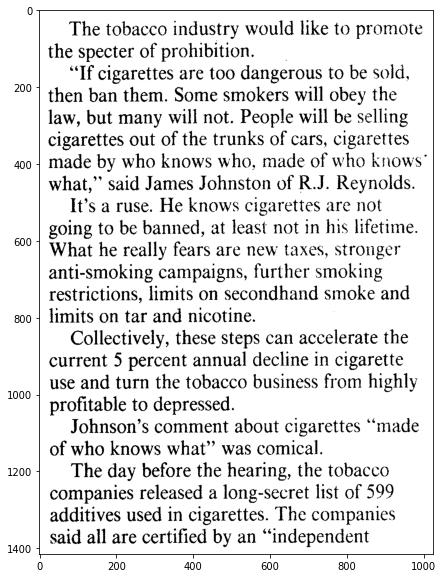

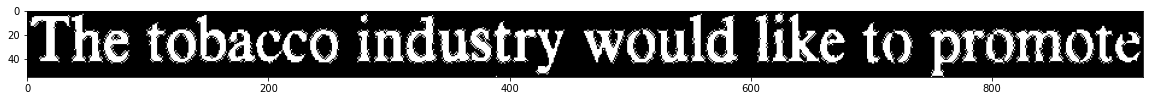

Model: 2lstm_new -> ThetobacoinduxtrywouldliketoPromote 
Model: 2lstm -> T%%%9%8%t%W%9wew 
Model: 3gru -> A%A0AAA4:M9Ak4ks6WpMAAtr 
Model: lstm_gru -> T#%%95##13~%445&0m%%%% 
Model: attention_new -> Thetobcoindustrypoud(ixetopeomoteo 
Model: attention -> I@hsAo+b<ssoiod<wA<i5wov+AJissYoiovoAmoJsi 


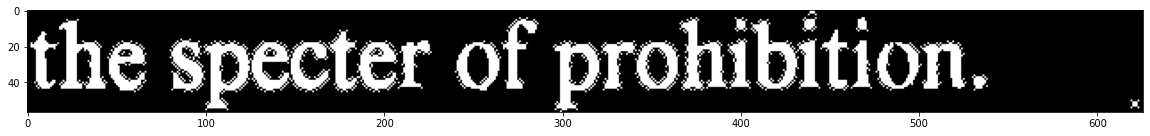

Model: 2lstm_new -> hexpcterofproibtiom. 
Model: 2lstm -> hewofwkto_ 
Model: 3gru -> k4AXA0BAABti., 
Model: lstm_gru -> %wg&*mWt._, 
Model: attention_new -> teseterfpotdtbtiomn.o 
Model: attention -> khaoDspis<vwvDiofmoDoDhibim.Di 


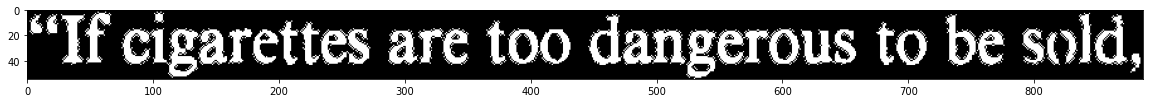

Model: 2lstm_new -> Figarettearetbodangeroustobesad, 
Model: 2lstm -> T%%%%C%%%C%96%%%%%%%% 
Model: 3gru -> R44AttAA=1Aw&A$A0AsNWAA, 
Model: lstm_gru -> ##44##%4%40444%%#%W$4, 
Model: attention_new -> Tcigaretesaretodageroustoesold, 
Model: attention -> "Jis+<.%3s.avs.J~oJo-d-Jos<vovssoav=s-JAd,.D-D 


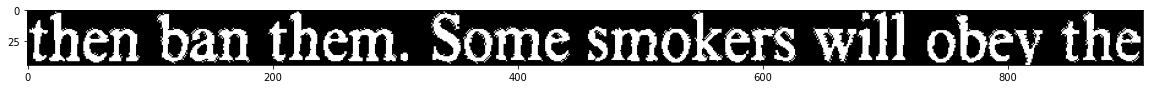

Model: 2lstm_new -> henbanthem.Somesmokerswillobeythe 
Model: 2lstm -> BM0Them%$%%%Y%lloP 
Model: 3gru -> AmMANA1A=M-AAMr$m9k#XMsx1Ae 
Model: lstm_gru -> P#*TMM.W%###%W70M7M 
Model: attention_new -> enbenthem.Somesmokerswilobevtheo 
Model: attention -> <b-asoJ-J<=m-.io.ms$m_o#3S~siJJ[o<v-Js-D-D- 


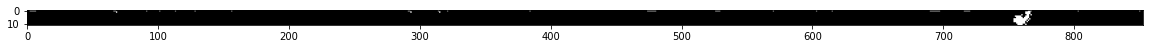

Model: 2lstm_new -> & 
Model: 2lstm -> f 
Model: 3gru -> ^ 
Model: lstm_gru -> * 
Model: attention_new -> " 
Model: attention -> 0o 


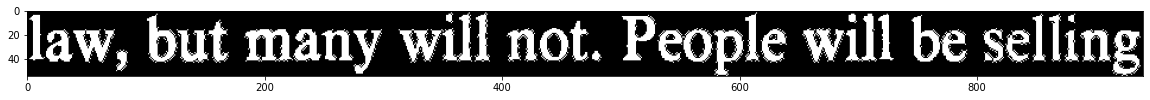

Model: 2lstm_new -> aw,bptmanywilmot.Peoplewillbeselling 
Model: 2lstm -> e%,%Cee%%Y%%%l%e%s 
Model: 3gru -> M,MAA%M4A4.R=9sMiWAlAws 
Model: lstm_gru -> +W,Wm40WP#4.#&%W%WIIW/WWms 
Model: attention_new -> ax,butmanyAilmotPeopleAilbeselingo 
Model: attention -> Aoiw,s.wDm-oosiwi[Do-.soo[s-Di[[sDsAJi-sD 


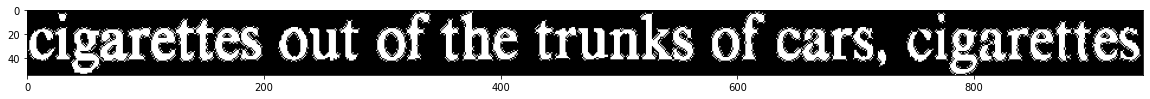

Model: 2lstm_new -> igzretteoutfthetrunkxofcarsciparttes 
Model: 2lstm -> %%%%8C%C%Y6%%&%&%%% 
Model: 3gru -> $A4A94%1A1wAk%A%.<$A#XA 
Model: lstm_gru -> 4##%%###%#4P%%4%,#44#% 
Model: attention_new -> igretesoutofthetrunksofcarcs,cigereteso 
Model: attention -> <is~J~$Do-w_JA-J_sD_J<D_oksoA-J~+_.Dis-D<.JSDi 


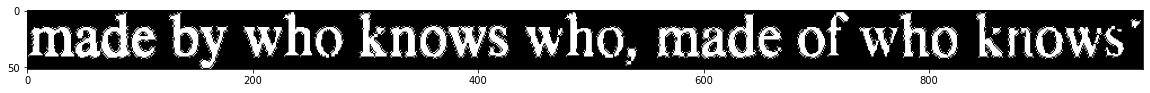

Model: 2lstm_new -> madebywhoknowswho,madeofwhoknows 
Model: 2lstm -> %%%YP9%%%%19*%9*%$%%%' 
Model: 3gru -> AAM^19%AMA%%.RAS%%Ak9MS' 
Model: lstm_gru -> %%%#7%#%%%WP%,##4%W*%W%W%' 
Model: attention_new -> madebywhoknoxswho,madeofwhoknoxsto 
Model: attention -> m~A~#$~#~0~4~0M5~#~i~%,Dmo~&~#~0~#<0~0M4S'~i 


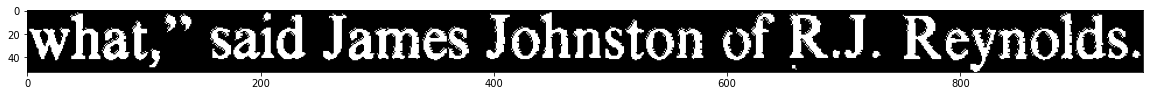

Model: 2lstm_new -> what/sadJamesJohnstonofR).Remolds. 
Model: 2lstm -> feX"$6/4%/9rS790%X/-K%%9%%- 
Model: 3gru -> A4A1"BA4JAAA4918/AR%/-:R9AA- 
Model: lstm_gru -> W#4/"#44J4#%9P/%0WKJ.4%%%4%. 
Model: attention_new -> whatadJamesJohmnstonofR.l.Reynolds.o 
Model: attention -> w.hieJ.".A~iAiJ-DmAsA.J~J5JsJ0J.0/.D4-JD.B<4~3J0JA-.-D 


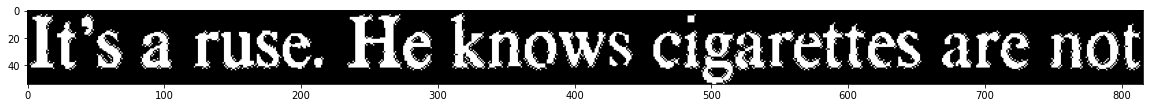

Model: 2lstm_new -> tsaruseReknowscigarettesarenot 
Model: 2lstm -> CS%t%-F%<6%&&%%e&% 
Model: 3gru -> (AArm.EAkA%A$AA#s4tsnW 
Model: lstm_gru -> %414%.5%W%W%%&4%#%4#sM% 
Model: attention_new -> tsaruse.Heknowscigeretesarenato 
Model: attention -> As'A-A-AD_Sv-DH_s-s.DosvsDsis-D.@<SD<DsDoD- 


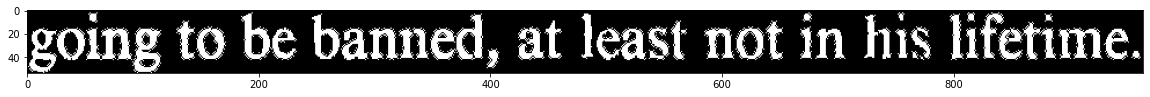

Model: 2lstm_new -> goingtobebamed,atlestnotinhislftime. 
Model: 2lstm -> %%%%%%%%,%%%%%%01%%%%% 
Model: 3gru -> MAANWAAA,AIAXAAAMARAAe. 
Model: lstm_gru -> %#%%WW4#4,4##7W*W*#P%. 
Model: attention_new -> gonegtoebamed,ateastnotinhisfetime.o 
Model: attention -> Aoios~-AoDi~s-b~oDmAd,.AJ~JA$A-D0J-iDsA-AJ<iAmD~.-DA 


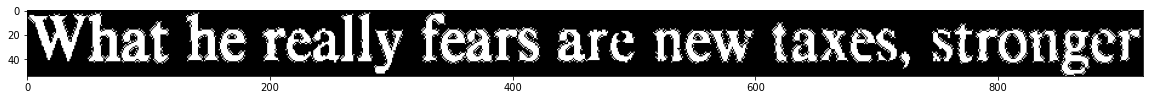

Model: 2lstm_new -> Whathereallyfearsarenewtaxes,stpmger 
Model: 2lstm -> Y%%%Y%%%%%%%%%%,%%%% 
Model: 3gru -> MAXA$44AAAAsAMA%AMAM 
Model: lstm_gru -> */#%#4%#4%#s##%44%,4%% 
Model: attention_new -> ThatHereayfersarenetaes,strongero 
Model: attention -> AMyh~-s-<J~JA<~S-Av~s-~<3v~J~3~,[$JD~0J~s~-- 


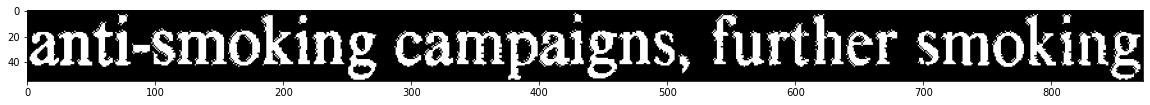

Model: 2lstm_new -> ntsmokingcampagns,furthersmoking 
Model: 2lstm -> 6-wewknx&mens6wtefsmokn& 
Model: 3gru -> NAwki-g$AmpA@s.*NAtsmoking 
Model: lstm_gru -> %P%/ng=wmwenswMtwm>Wm& 
Model: attention_new -> antismokingcampaigns,furthersmokingo 
Model: attention -> eDi-smiosios-soimoisnoi,?AwDvbsv-smAosiosDi 


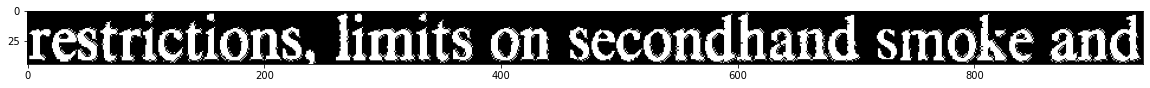

Model: 2lstm_new -> etictions,imitsomscomdhandsmokeand 
Model: 2lstm -> 6%%%#&%%$<%814%sr%%%4 
Model: 3gru -> #4%A'ARAmSA$%AABAA%mAkeA4 
Model: lstm_gru -> ###%.W#/%44#%4#44wm%444 
Model: attention_new -> estrictions.imitsonseondhandsmokeando 
Model: attention -> <J%<J<Ji0J$D-AimAiA$JOJQ-$s<soJmAdioJAdDsmoJ$DJAJdJD 


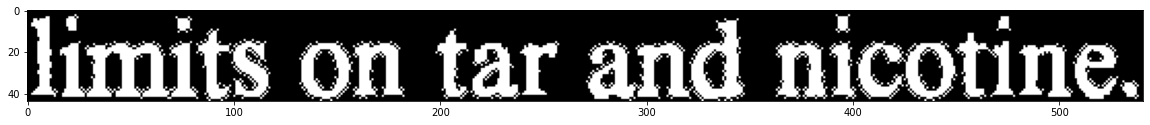

Model: 2lstm_new -> imtsmtarandnotne. 
Model: 2lstm -> W%%%&f%%%%6%- 
Model: 3gru -> AAA'At4AAMAAAA 
Model: lstm_gru -> #W##144##%+%. 
Model: attention_new -> imitsontarandniceotince. 
Model: attention -> imiADJomADoDdAmDi+oJimD.Do 


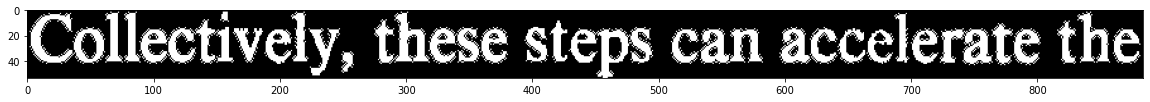

Model: 2lstm_new -> Colextivey,thekesteBcanAceleratethe 
Model: 2lstm -> %%%%*%%%%%%%%%%%%%% 
Model: 3gru -> AAA?64%.%AA%4%AA=AA%(A 
Model: lstm_gru -> 49##%4%,##%4#%44%4%%#%%P% 
Model: attention_new -> Cdetively,thesestegscanaeteaetetheoo 
Model: attention -> G~JA~J~iJ<J~%.-A<$~-A~<5D4-$~-A=~s<%<3~3~3~As<_D- 


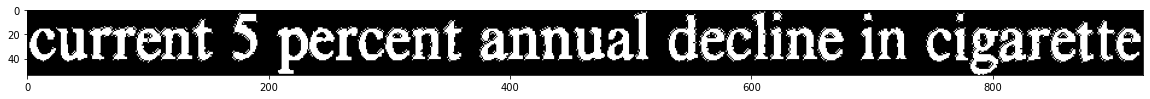

Model: 2lstm_new -> uremtSperremtanmualdcimeincipartte 
Model: 2lstm -> 6%/0%%C%9%%%%0<&%% 
Model: 3gru -> 44AD$=%A1AAA4AAAA$4A#C< 
Model: lstm_gru -> +#W###444##%PK&4#% 
Model: attention_new -> curemtSpercentannualdeclimeincigareteo 
Model: attention -> <vAvDvD-J-sD<vJvsv--A-Dv-e+-A=<sJiJ=D-i0-sis-v<-J<-D- 


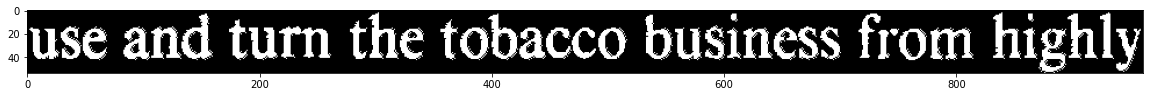

Model: 2lstm_new -> keandtumthetobacobusinesfromhighly 
Model: 2lstm -> W%4%50%7%%96%%To%F&B% 
Model: 3gru -> 444-M(s(WARA9AAXF0AHi&4I3 
Model: lstm_gru -> #%4#7##%(44%0P4W%%F10M*&PV 
Model: attention_new -> seandtumthetobacobusinessfromhighlyo 
Model: attention -> D~As~-#AJ0~%~$~s~0s~$i~$5sAoJmsisi[$ 


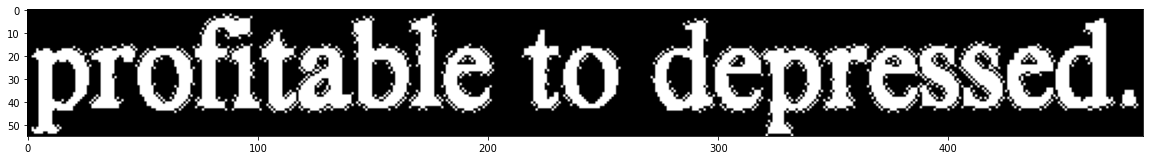

Model: 2lstm_new -> roftabetoderesed. 
Model: 2lstm -> 9%8%%0%%%%- 
Model: 3gru -> AAASAAA- 
Model: lstm_gru -> %4%%#4%4. 
Model: attention_new -> roftedbdetodepresed.o 
Model: attention -> oDoAi-DiA<D4oDADoDxDdA-Di 


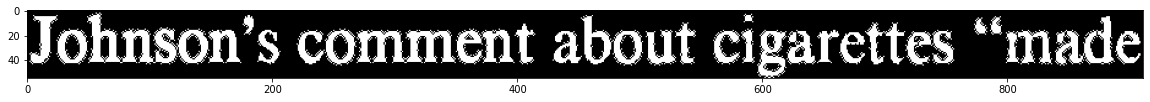

Model: 2lstm_new -> omomscommentaboutcigzrettes(made 
Model: 2lstm -> %%/%%ete%C%rSt%"e% 
Model: 3gru -> MAAA's=AAAtA/A44A#A"AAAs 
Model: lstm_gru -> #4N$4##04W#%&er##%"m4 
Model: attention_new -> lounsoscaoeetaboutcigaretesimdeo 
Model: attention -> DoJhioDAm'sAsoDm-Do"Dsbow+-<is-D<.vA".modAvDi 


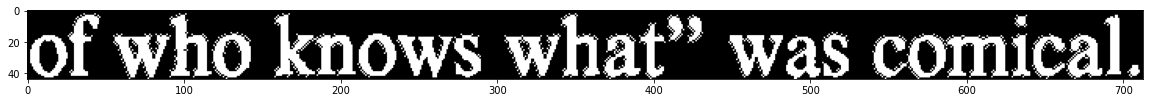

Model: 2lstm_new -> fwhoknowswhat/wascomical. 
Model: 2lstm -> 99X%%0e*%%%m%l- 
Model: 3gru -> %AkA9MMA"%A=AmAl- 
Model: lstm_gru -> /W$%W#4"W%#M#]. 
Model: attention_new -> fwhokemoxvswhatwascomiceal.oo 
Model: attention -> oFiwibo-sovo-wswvbA"-s=ssoAmis-[-Di 


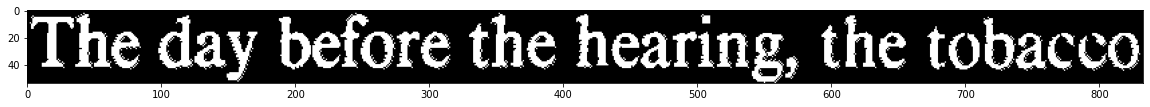

Model: 2lstm_new -> Thedaybeforethehearingthetobacco 
Model: 2lstm -> T%4%/6e%&eteem&betoke<w 
Model: 3gru -> A4:bARs(shsAiw'rtobA 
Model: lstm_gru -> T%4w/W%<%Metin&h=te%% 
Model: attention_new -> Thedayeforethehearing,thetohacoo 
Model: attention -> I@h-dpYai<Ao<Ybshis-ios.Abssoiasso-Di 


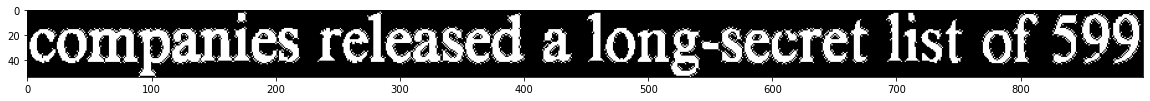

Model: 2lstm_new -> ompamlesreleaedalongsecretistf599 
Model: 2lstm -> %%%%f<%8%/68%%%W%9 
Model: 3gru -> 4QAA1e4AAA4'W$AA#A^D% 
Model: lstm_gru -> ####%(####%4W#&###/W4#W% 
Model: attention_new -> cmpeiesrelesedalongseretistofS9o 
Model: attention -> soAmDo-Di~ADA~4J~J<3AD~-AoJos-D3vD<3DAisJ-oAD5D9~3Di 


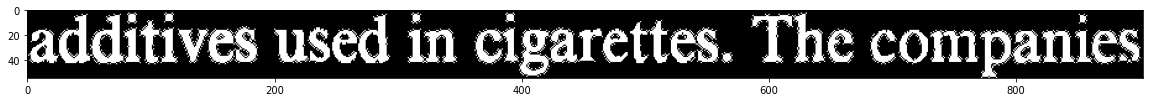

Model: 2lstm_new -> dditveusedndiperete.Thecompanies 
Model: 2lstm -> %%%%%%8%%8%C%T%&m%% 
Model: 3gru -> AAMAAAA%AtA7X=44@AAA 
Model: lstm_gru -> 4##%%4#4P%44##4%.T*&#4*% 
Model: attention_new -> ditivesusedincigeretes.Thecompanieso 
Model: attention -> AJA4A4-D_$<AAiD-<JA4JDJ~J<J-DCbs.s<oDmoDiADi 


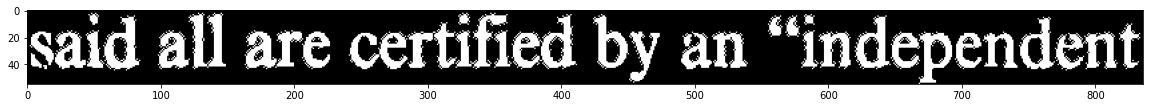

Model: 2lstm_new -> adAlareertfedbyan(independent 
Model: 2lstm -> %8%14%%%%6%e"%eeet 
Model: 3gru -> AAAe=AANAA"A=9=mAAA 
Model: lstm_gru -> #%444%###W4W4"m%menm 
Model: attention_new -> aidaarecertfiedbya"independento 
Model: attention -> soid~AJ-Dv<D^v<4iAi=0D-"iodvovDmd<oDi 


In [23]:
img = './TestDataset/TestData/8200_006.4B.png'
extract_text(img)

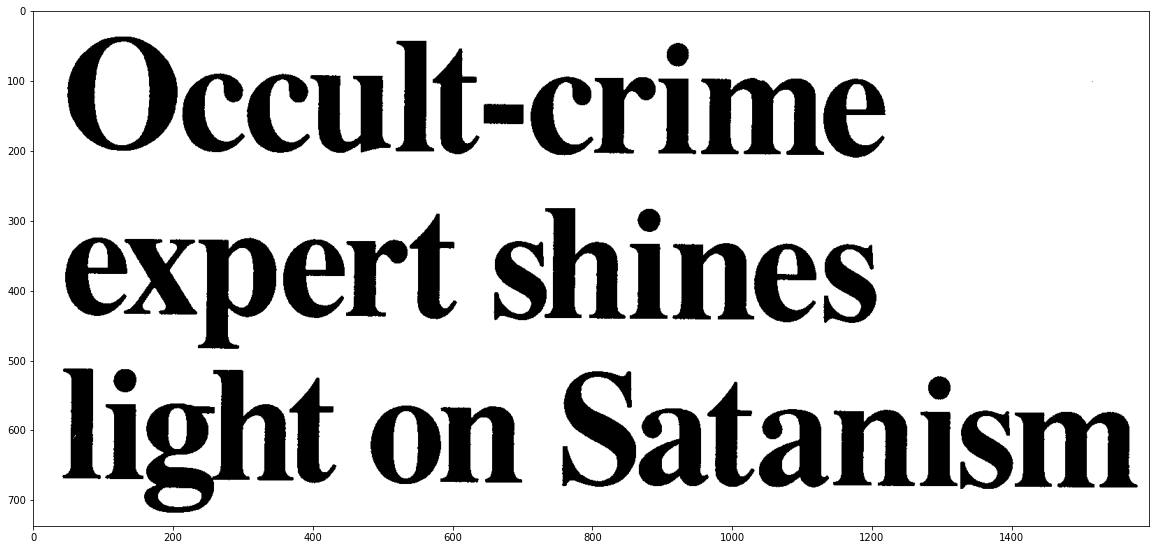

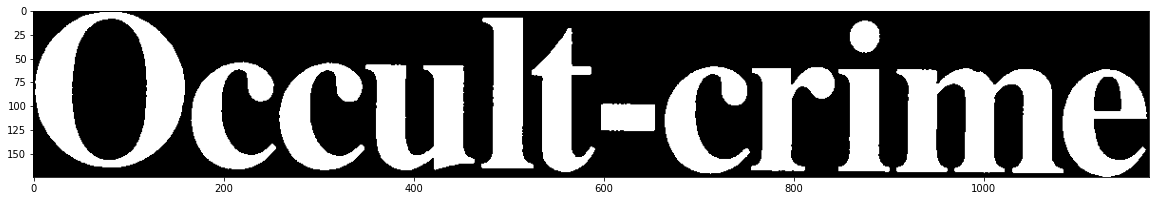

Model: 2lstm_new -> CDccult-crime 
Model: 2lstm -> Occut-crime 
Model: 3gru -> ccult-crime 
Model: lstm_gru -> Occult-crime 
Model: attention_new -> Cceut-erime 
Model: attention -> OmDmAih-mDoimeDi 


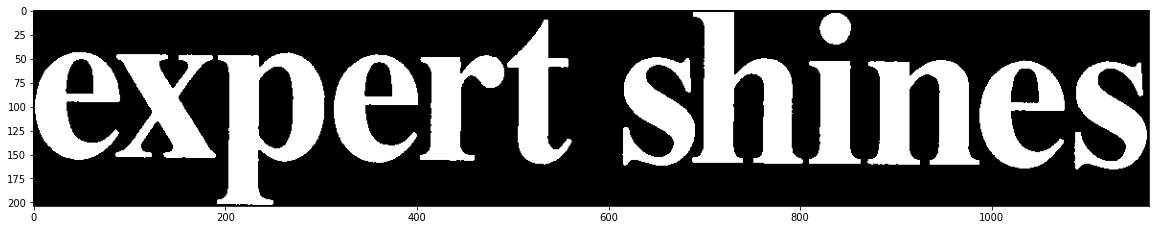

Model: 2lstm_new -> xpertshines 
Model: 2lstm -> P*TTS 
Model: 3gru -> P*I%4I% 
Model: lstm_gru -> /PFT/WPIT% 
Model: attention_new -> xpertshines 
Model: attention -> %D^PD@JDAD05DA 


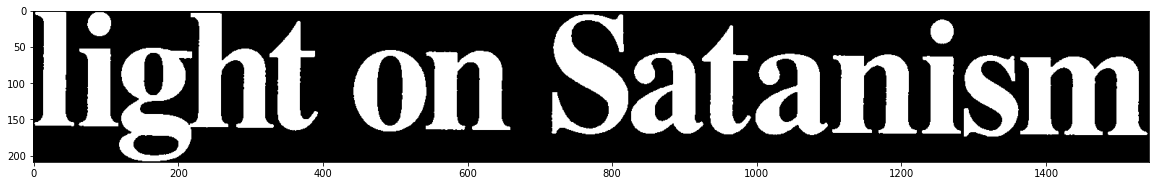

Model: 2lstm_new -> ightonSGatanism 
Model: 2lstm -> &F91S44tiSh 
Model: 3gru -> 444AA4IAiA 
Model: lstm_gru -> E/77W440sM 
Model: attention_new -> ightonSatanism 
Model: attention -> DJD$DJDmismDi 


In [26]:
img = './TestDataset/TestData/8200_014.4B_TITLE.png'
extract_text(img)